# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import random
import seaborn as sns 
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from scipy      import stats           as ss
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from imblearn import under_sampling as us
from imblearn import over_sampling  as osamp
from imblearn import combine        as comb

from keras import models as ml
from keras import layers as l

warnings.filterwarnings('ignore')

## 0.1. Auxiliar Functions

In [68]:
def cross_validation(num_fold, x_train, y_train, model, response_encoder, balance_model=False, verbose=False):
    # generate k-fold
    num_folds = 5
    kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

    # create empty metrics list
    acc_list = []
    balanced_acc_list = []
    kappa_list = []

    # sequence of loop for verbose
    i = 1
    
    # interation to measure performance
    for train_index, val_index in kfold.split( x_train, response_encoder.inverse_transform(y_train) ):
        if verbose:
            print(f'Fold Number:{i}/{num_folds}')

        # split data into training and test set
        x_train_cv = x_train.iloc[train_index]
        y_train_cv = y_train.iloc[train_index]

        x_validation_cv = x_train.iloc[val_index]
        y_validation_cv = y_train.iloc[val_index]
        
        # balance of dataset
        if balance_model != False:
            # resample the dataset
            x_train_cv, y_train_cv = balance_model.fit_resample(x_train_cv, response_encoder.inverse_transform(y_train_cv))
            
            # convert back to encoding representation
            y_train_cv = pd.DataFrame(response_encoder.transform(y_train_cv.reshape(-1,1)).toarray(), 
                                      columns=response_encoder.categories_[0], 
                                      index=x_train_cv.index)

        # train model
        model.fit(x_train_cv, y_train_cv, epochs=100, batch_size=32, verbose=0)

        # prediction
        pred_cv = model.predict(x_validation_cv)

        # invert prediction
        yhat_cv = response_encoder.inverse_transform(pred_cv)

        # invert validation response
        y_test_cv = response_encoder.inverse_transform(y_validation_cv)

        # performance metrics
        # Accuracy
        acc_model = m.accuracy_score( y_test_cv, yhat_cv )
        acc_list.append(acc_model)
        
        # Balanced Accuracy
        balanced_acc_model = m.balanced_accuracy_score(y_test_cv, yhat_cv)
        balanced_acc_list.append(balanced_acc_model)

        # Kappa Metrics
        kappa_model = m.cohen_kappa_score(y_test_cv, yhat_cv)
        kappa_list.append(kappa_model)

        i += 1

    return acc_list, balanced_acc_list, kappa_list


def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    rcorr = r - ((r-1)**2)/(n-1)
    
    kcorr = k - ((k-1)**2)/(n-1)
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data

In [3]:
# load training set of user
data_users = pd.read_csv('../Datasets/train_users_2.csv', low_memory=False)

# load web sessions log for users
data_sessions = pd.read_csv('../Datasets/sessions.csv', low_memory=False)

In [4]:
# load test users
data_test = pd.read_csv('../Datasets/test_users.csv', low_memory=False)

# 1.0. Data Description

In [5]:
df01_users = data_users.copy()

df01_sessions = data_sessions.copy()

## 1.1. Data Types

In [6]:
df01_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [7]:
df01_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.2. Data Dimensions

### 1.2.1. Data Users Dimensions 

In [8]:
print( f'Number of rows of users dataset: {df01_users.shape[0]}')
print( f'Number of columnss of users dataset: {df01_users.shape[1]}')

Number of rows of users dataset: 213451
Number of columnss of users dataset: 16


### 1.2.2. Data Sessions Dimensions

This dataset will not be used in this first cycle due to the granularity being action and we want to be user_id for now.

In [9]:
print( f'Number of rows of sessions dataset: {df01_sessions.shape[0]}')
print( f'Number of columnss of session dataset: {df01_sessions.shape[1]}')

Number of rows of sessions dataset: 10567737
Number of columnss of session dataset: 6


## 1.3. Check NA

### 1.3.1. Check NA - Data Users

In [10]:
df01_users.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [11]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

### 1.3.2. Check NA - Data Sessions

In [12]:
df01_sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [13]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Fillout NA

### 1.4.1. Fillout NA - Data Users

- **date_first_booking:** the maximum date of the dataset is chosen due to future features considered the space between dates.

- **age:** variable age has a normal distribution, so replacing it with with a mean value will not bias the dataset.

- **first_affiliate_tracked:** due to the high probability of bias the dataset with categorical data substitution and the low amount of NA datas in this variable, the NA lines will be dropped.

In [14]:
# date_first_booking
max_date_first_booking = pd.to_datetime(df01_users['date_first_booking']).max().strftime('%Y-%m-%d')
df01_users['date_first_booking'] = df01_users['date_first_booking'].fillna(max_date_first_booking)

# age
avg_age = int(df01_users['age'].mean())
df01_users['age'] = df01_users['age'].fillna(avg_age)

# first_affiliate_tracked
df01_users = df01_users[~df01_users['first_affiliate_tracked'].isna()]

In [15]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

### 1.4.2. Fillout NA - Data Sessions

Due to a massise amount of data, all NA lines will be dropped.

In [16]:
# user_id  - 0.003264
df01_sessions = df01_sessions[~df01_sessions['user_id'].isna()]

# action - 0.007535
df01_sessions = df01_sessions[~df01_sessions['action'].isna()]

# action_type - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_type'].isna()]

# action_detail - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_detail'].isna()]

# secs_elapsed - 0.012872
df01_sessions = df01_sessions[~df01_sessions['secs_elapsed'].isna()]

In [17]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5. Change Data Type

In [18]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
22660,lxjcosootz,2012-04-29,20120429202000,2015-06-29,MALE,34.0,facebook,0,en,seo,google,linked,Web,iPad,Mobile Safari,NDF


In [19]:
# change date type
df01_users['date_account_created'] = pd.to_datetime(df01_users['date_account_created'])
df01_users['date_first_booking'] = pd.to_datetime(df01_users['date_first_booking'])

# change datetime type
df01_users['timestamp_first_active'] = pd.to_datetime(df01_users['timestamp_first_active'], format='%Y%m%d%H%M%S')

# change age to int
df01_users['age'] = df01_users['age'].astype(np.int64)

In [20]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
154525,xzf8jkz3d1,2014-02-19,2014-02-19 06:03:54,2015-06-29,FEMALE,26,facebook,12,en,api,other,untracked,iOS,iPhone,-unknown-,NDF


In [21]:
df01_users.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

Data with an unbalance of 57% for the NDF class and 30% for the US class.

In [22]:
df01_users['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.7. Descriptive Analysis

In [23]:
# split data users in types dataframes
num_attributes_users = df01_users.select_dtypes(include=['int64', 'float64'])
cat_attributes_users = df01_users.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_users = df01_users.select_dtypes(include=['datetime64[ns]'])

# split data sessions in types dataframes
num_attributes_sessions = df01_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df01_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df01_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1. Numerical - Data Users

In [24]:
# tendency central - mean and median
mean_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.mean(x)))
median_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max()))
min_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.min()))
range_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max() - x.min()))
std_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.std(x)))
skew_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.skew()))
kurtosis_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_users = pd.concat([max_users, min_users, range_users, mean_users, 
                             median_users, std_users, skew_users, kurtosis_users], axis=1).reset_index()
num_stats_users.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_users

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,age,2014,1,2013,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,25,0,25,3.151490,0.0,7.543915,2.287158,3.567794


### 1.7.2. Numerical - Data Sessions

In [25]:
# tendency central - mean and median
mean_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.mean(x)))
median_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max()))
min_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.min()))
range_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min()))
std_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.std(x)))
skew_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew()))
kurtosis_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_sessions = pd.concat([max_sessions, min_sessions, range_sessions, mean_sessions, 
                             median_sessions, std_sessions, skew_sessions, kurtosis_sessions], axis=1).reset_index()
num_stats_sessions.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_sessions

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,secs_elapsed,1799977.0,0.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.7.3. Categorical - Data Users

In [26]:
cat_attributes_users.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


#### 1.7.3.1. Correlation Matrix

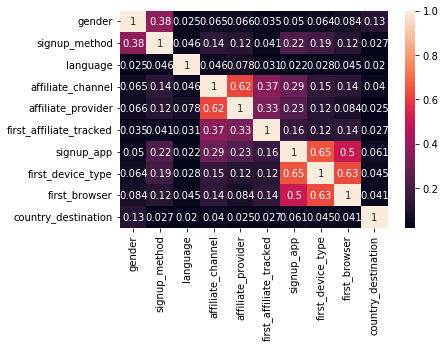

In [27]:
cat_attributes_users_columns = cat_attributes_users.drop('id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_users_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_users_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_users[main_column], cat_attributes_users[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_users = pd.DataFrame(corr_dict)
df_corr_users = df_corr_users.set_index(df_corr_users.columns)
sns.heatmap(df_corr_users, annot=True);

### 1.7.4. Categorical - Data Sessions

In [28]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


#### 1.7.4.1. Correlation Matrix

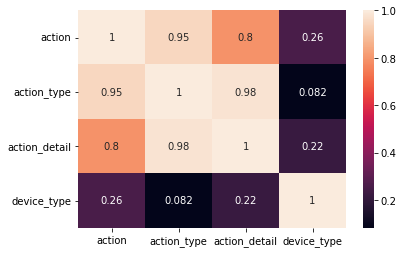

In [29]:
cat_attributes_sessions_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_sessions_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_sessions_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_sessions[main_column], cat_attributes_sessions[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_sessions = pd.DataFrame(corr_dict)
df_corr_sessions = df_corr_sessions.set_index(df_corr_sessions.columns)
sns.heatmap(df_corr_sessions, annot=True);

# 2.0. Feature Engineering

In [30]:
df02_users = df01_users.copy()

## 2.1. Create Gap Between Dates Features

In [31]:
# date of first active
df02_users['date_first_active'] = pd.to_datetime(df02_users['timestamp_first_active'].dt.strftime("%Y-%m-%d"))

# difference in days between date_account_created and date_first_active
df02_users['diff_account_created_first_active'] = (df02_users['date_account_created'] - df02_users['date_first_active']).apply(lambda x: x.days)

# difference in days between date_account_created and date_first_booking
df02_users['diff_first_booking_account_created'] = (df02_users['date_first_booking'] - df02_users['date_account_created']).apply(lambda x: x.days)

# difference in days between date_first_active and date_first_booking
df02_users['diff_first_active_first_booking'] = (df02_users['date_first_booking'] - df02_users['date_first_active']).apply(lambda x: x.days)

## 2.2. Create Date Features

### 2.2.1. Account Created

In [32]:
# year
df02_users['year_account_created'] = df02_users['date_account_created'].dt.year

# month
df02_users['month_account_created'] = df02_users['date_account_created'].dt.month

# day
df02_users['day_account_created'] = df02_users['date_account_created'].dt.day

# day of week
df02_users['dayofweek_account_created'] = df02_users['date_account_created'].dt.dayofweek

# week of year
df02_users['weekofyear_account_created'] = df02_users['date_account_created'].dt.weekofyear

### 2.2.2. First Active

In [33]:
# year
df02_users['year_first_active'] = df02_users['date_first_active'].dt.year

# month
df02_users['month_first_active'] = df02_users['date_first_active'].dt.month

# day
df02_users['day_first_active'] = df02_users['date_first_active'].dt.day

# day of week
df02_users['dayofweek_first_active'] = df02_users['date_first_active'].dt.dayofweek

# week of year
df02_users['weekofyear_first_active'] = df02_users['date_first_active'].dt.weekofyear

### 2.2.3. First Booking

In [34]:
# year
df02_users['year_first_booking'] = df02_users['date_first_booking'].dt.year

# month
df02_users['month_first_booking'] = df02_users['date_first_booking'].dt.month

# day
df02_users['day_first_booking'] = df02_users['date_first_booking'].dt.day

# day of week
df02_users['dayofweek_first_booking'] = df02_users['date_first_booking'].dt.dayofweek

# week of year
df02_users['weekofyear_first_booking'] = df02_users['date_first_booking'].dt.weekofyear

# 3.0. Data Filtering

In [35]:
df03_users = df02_users.copy()

## 3.1. Filtering Rows

In [36]:
# age - greater than 15 and lower than 100 - There are few people over 100 years old ( Could be error from system or manual imput - Cleaning noise)
df03_users = df03_users[(df03_users['age'] > 15) & (df03_users['age'] < 100)]

# secs_elapsed - there is no possible 0 secs elapesed on website
#df03_sessions = df03_sessions[df03_sessions['secs_elapsed'] > 0]

## 3.2. Columns Selection

In [37]:
# columns id not carry any information
df03_users = df03_users.drop(['id'], axis=1)

# columns used to feature enginnering
cols_date =['timestamp_first_active',
            'date_first_active',
            'date_account_created',
            'date_first_booking']

# drop select columns 
cols_drop = cols_date
df03_users = df03_users.drop(columns=cols_drop)

# 4.0. Data Exploratory Analysis

To increase time, the EDA stage will be skipped in this first cycle.

In [38]:
df04_users = df03_users.copy()

# 5.0. Data Preparation

In [39]:
df05_users = df04_users.copy()

## 5.1. Encoding

In [40]:
# dummy variable
df05_users_dummy = pd.get_dummies(df05_users.drop(['country_destination'], axis=1))

# join id and country destination
df05_users = pd.concat( [df05_users['country_destination'], df05_users_dummy], axis=1 )

## 5.2. Response Variable

In [41]:
# create OneHotEncoder instance
ohe = pp.OneHotEncoder()

# ohe hot encoding response feature
df_ohe = pd.DataFrame(ohe.fit_transform(df05_users['country_destination'].values.reshape(-1,1)).toarray(),
                      columns=ohe.categories_[0],
                      index=df05_users.index)

# joining encoded response feature to dataset
df05_users = pd.concat([df05_users.drop(columns=['country_destination']), df_ohe], axis=1)

# 6.0. Feature Selection

In [42]:
df06_users = df05_users.copy()

## 6.1. Split Dataframe into Training and Test Dataset

In [43]:
# training dataset
X = df06_users.drop( columns=ohe.categories_[0] )

#  training response dataset
y = df06_users[ohe.categories_[0]]

In [44]:
# Split dataset into training and test (validation)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

## 6.2. Balanced Dataset

### 6.2.1. Random Undersampling

In [45]:
# define sampler - random under-sampling
undersampling = us.RandomUnderSampler(sampling_strategy='not minority', random_state=32)

# resample the dataset
X_train_under, y_train_under = undersampling.fit_resample(X_train, ohe.inverse_transform(y_train))

In [46]:
pd.DataFrame(ohe.inverse_transform(y_train)).value_counts()

NDF      95544
US       47937
other     7851
FR        3877
IT        2203
GB        1790
ES        1750
CA        1086
DE         797
NL         583
AU         421
PT         176
dtype: int64

In [47]:
pd.DataFrame(y_train_under).value_counts()

AU       176
CA       176
DE       176
ES       176
FR       176
GB       176
IT       176
NDF      176
NL       176
PT       176
US       176
other    176
dtype: int64

In [48]:
# convert back to encoding representation
y_train_under = pd.DataFrame(ohe.transform(y_train_under.reshape(-1,1)).toarray(), 
                             columns=ohe.categories_[0], 
                             index=X_train_under.index)

### 6.2.2. Random Oversampling

In [49]:
# define sampler - random over-sampling
oversampling = osamp.RandomOverSampler(sampling_strategy='not majority', random_state=32)

# resample the dataset
X_train_over, y_train_over = oversampling.fit_resample(X_train, ohe.inverse_transform(y_train))

In [50]:
pd.DataFrame(ohe.inverse_transform(y_train)).value_counts()

NDF      95544
US       47937
other     7851
FR        3877
IT        2203
GB        1790
ES        1750
CA        1086
DE         797
NL         583
AU         421
PT         176
dtype: int64

In [51]:
pd.DataFrame(y_train_over).value_counts()

AU       95544
CA       95544
DE       95544
ES       95544
FR       95544
GB       95544
IT       95544
NDF      95544
NL       95544
PT       95544
US       95544
other    95544
dtype: int64

In [52]:
# convert back to encoding representation
y_train_over = pd.DataFrame(ohe.transform(y_train_over.reshape(-1,1)).toarray(), 
                            columns=ohe.categories_[0], 
                            index=X_train_over.index)

### 6.2.3. SMOTE + TOMEKLINK

In [53]:
# define sampler - over-sampling using SMOTE and cleaning using Tomek links
combine = comb.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

# resample the dataset
X_train_comb, y_train_comb = combine.fit_resample(X_train, ohe.inverse_transform(y_train))

In [54]:
pd.DataFrame(ohe.inverse_transform(y_train)).value_counts()

NDF      95544
US       47937
other     7851
FR        3877
IT        2203
GB        1790
ES        1750
CA        1086
DE         797
NL         583
AU         421
PT         176
dtype: int64

In [55]:
pd.DataFrame(y_train_comb).value_counts()

NDF      95542
PT       95531
AU       95530
NL       95510
DE       95507
CA       95476
ES       95451
GB       95445
IT       95402
FR       95277
other    94886
US       94489
dtype: int64

In [56]:
# convert back to encoding representation
y_train_comb = pd.DataFrame(ohe.transform(y_train_comb.reshape(-1,1)).toarray(), 
                            columns=ohe.categories_[0], 
                            index=X_train_comb.index)

# 7.0. Machine Learing Model

In [58]:
# imbalanced dataset
x_train = X_train
x_test = X_test

# random undersampling
x_train_under = X_train_under

# random oversampling
x_train_over = X_train_over

# SMOTE + Tomek Links
x_train_comb = X_train_comb

## 7.1. Baseline Model - Random

In [59]:
# list of country destination
country_list = ohe.categories_[0].tolist()

# number of rows
k_num = y_test.shape[0]

# proportion of country destinations for imbalanced result
df_ohe = pd.DataFrame(ohe.inverse_transform(df06_users[ohe.categories_[0]]))
country_weights = df_ohe.value_counts(normalize=True).sort_index().tolist()

# prediction
yhat_random = random.choices(population=country_list,
                             weights=country_weights,
                             k=k_num)

# invert validation response
y_test_random = ohe.inverse_transform(y_test)

### 7.1.1. Baseline Model - Performance

Accuracy 0.4265437518290898
Balanced Accuracy: 0.08389706302635076
Kappa Score: 0.0014673913511207282
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        98
          CA       0.01      0.01      0.01       283
          DE       0.00      0.00      0.00       227
          ES       0.01      0.01      0.01       433
          FR       0.03      0.04      0.03       963
          GB       0.01      0.01      0.01       469
          IT       0.00      0.00      0.00       539
         NDF       0.58      0.58      0.58     23643
          NL       0.01      0.01      0.01       156
          PT       0.00      0.00      0.00        36
          US       0.30      0.30      0.30     12192
       other       0.05      0.05      0.05      1965

    accuracy                           0.43     41004
   macro avg       0.08      0.08      0.08     41004
weighted avg       0.43      0.43      0.43     41004



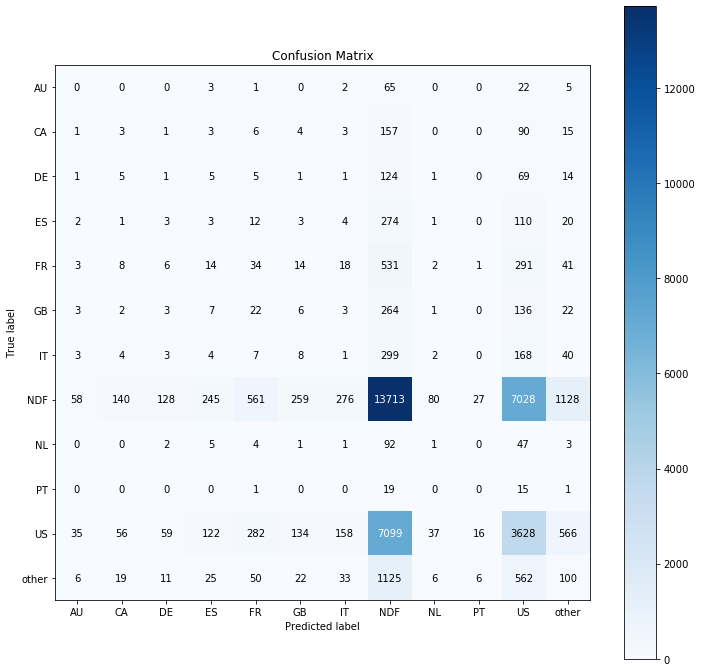

In [60]:
# Accuracy
acc_random = m.accuracy_score( y_test_random, yhat_random )
print(f'Accuracy {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test_random, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test_random, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification report
print(m.classification_report(y_test_random, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_random, yhat_random, normalize=False, figsize=(12,12));

# Performance
baseline_performance = {'model': 'Baseline Model',
                        'acc': acc_random,
                        'balanced_acc': balanced_acc_random,
                        'kappa_store': kappa_random}

## 7.2. Neural Network - MLP

### 7.2.1. Imbalanced Data

In [61]:
# model definition
model_nn = ml.Sequential()
model_nn.add( l.Dense(128, input_dim=x_train.shape[1], activation='relu') )
model_nn.add( l.Dense(12, activation='softmax') )

# model compile
model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_nn.fit(x_train, y_train, epochs=100)

Epoch 1/100
5126/5126 [==============================] - 9s 2ms/step - loss: 3.1678 - accuracy: 0.7980
Epoch 2/100
5126/5126 [==============================] - 9s 2ms/step - loss: 1.4088 - accuracy: 0.8165: 1s - loss: 1.5088 -  - E - ETA: 0s - loss: 1.4316 - accu
Epoch 3/100
5126/5126 [==============================] - 9s 2ms/step - loss: 0.7684 - accuracy: 0.8437
Epoch 4/100
5126/5126 [==============================] - 10s 2ms/step - loss: 0.5529 - accuracy: 0.8699 0s - loss: 0.555
Epoch 5/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.5001 - accuracy: 0.8739
Epoch 6/100
5126/5126 [==============================] - 7s 1ms/step - loss: 0.4949 - accuracy: 0.8742
Epoch 7/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4935 - accuracy: 0.8743
Epoch 8/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4938 - accuracy: 0.8743
Epoch 9/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4936 - accuracy: 0.87

5126/5126 [==============================] - 6s 1ms/step - loss: 0.4878 - accuracy: 0.8746
Epoch 78/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4871 - accuracy: 0.8747
Epoch 79/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4877 - accuracy: 0.8746
Epoch 80/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4884 - accuracy: 0.8745
Epoch 81/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4874 - accuracy: 0.8746
Epoch 82/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4880 - accuracy: 0.8746
Epoch 83/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4872 - accuracy: 0.8746
Epoch 84/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4881 - accuracy: 0.8746
Epoch 85/100
5126/5126 [==============================] - 6s 1ms/step - loss: 0.4875 - accuracy: 0.8746
Epoch 86/100
5126/5126 [==============================] - 6s 1ms/step - loss:

#### 7.2.1.1. Imbalanced Data - Perfomance

In [62]:
# prediction
pred_nn = model_nn.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# invert validation response
y_test_nn = ohe.inverse_transform(y_test)

In [63]:
# check the balance of validation
pd.DataFrame(y_test_nn).value_counts(normalize=True)

NDF      0.576602
US       0.297337
other    0.047922
FR       0.023486
IT       0.013145
GB       0.011438
ES       0.010560
CA       0.006902
DE       0.005536
NL       0.003805
AU       0.002390
PT       0.000878
dtype: float64

In [64]:
# check the balance of result
pd.DataFrame(yhat_nn).value_counts(normalize=True)

NDF    0.576773
US     0.423227
dtype: float64

Accuracy: 0.8737928007023705
Balanced Accuracy: 0.166625656167979
Kappa Score: 0.766969279113247
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        98
          CA       0.00      0.00      0.00       283
          DE       0.00      0.00      0.00       227
          ES       0.00      0.00      0.00       433
          FR       0.00      0.00      0.00       963
          GB       0.00      0.00      0.00       469
          IT       0.00      0.00      0.00       539
         NDF       1.00      1.00      1.00     23643
          NL       0.00      0.00      0.00       156
          PT       0.00      0.00      0.00        36
          US       0.70      1.00      0.82     12192
       other       0.00      0.00      0.00      1965

    accuracy                           0.87     41004
   macro avg       0.14      0.17      0.15     41004
weighted avg       0.79      0.87      0.82     41004



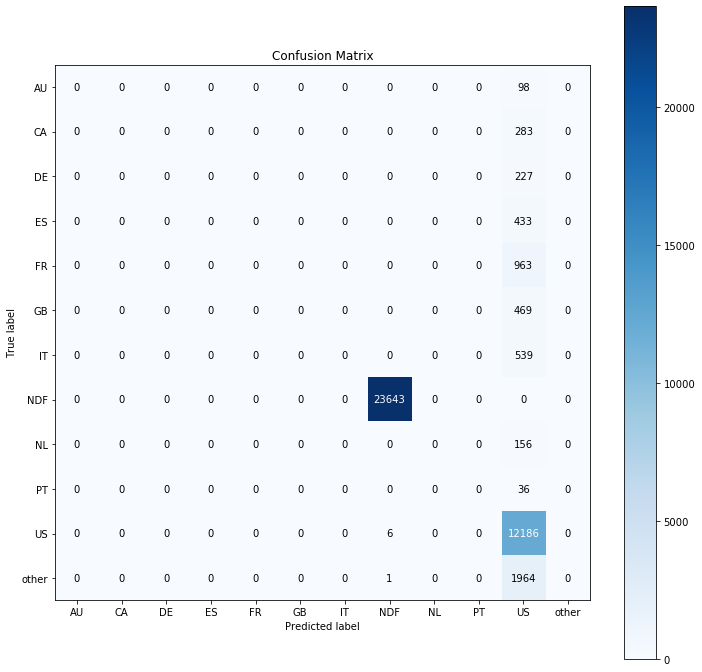

In [66]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

# Performance
imb_performance = {'model': 'NN Model - Imbalanced Data', 
                   'acc': np.round(acc_nn, 6), 
                   'balanced_acc': np.round(balanced_acc_nn, 6), 
                   'kappa_score': np.round(kappa_nn, 6)}

#### 7.2.1.2. Imbalanced Data - Cross-Validation

In [69]:
# cross validation performance
acc_nn, balanced_acc_nn, kappa_nn = cross_validation(num_fold = 5, 
                                                     x_train = X_train, 
                                                     y_train = y_train, 
                                                     model = model_nn, 
                                                     response_encoder = ohe, 
                                                     balance_model = False, 
                                                     verbose = True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [70]:
# Performance
imb_performance_cv = {'model': 'NN Model - Imbalanced Data - CV',
                        'acc': f'{np.round(np.mean(acc_nn), 2)} +/- {np.round(np.std(acc_nn), 4)}',
                        'balanced_acc': f'{np.round(np.mean(balanced_acc_nn), 2)} +/- {np.round(np.std(balanced_acc_nn), 4)}',
                        'kappa_score': f'{np.round(np.mean(kappa_nn), 2)} +/- {np.round(np.std(kappa_nn), 4)}'}

In [71]:
print(f'Avg Accuracy: {np.round(np.mean(acc_nn), 2)} +/- {np.round(np.std(acc_nn),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_nn), 2)} +/- {np.round(np.std(balanced_acc_nn),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_nn), 2)} +/- {np.round(np.std(kappa_nn), 4)}')

Avg Accuracy: 0.87 +/- 0.0001
Avg Balanced Accuracy: 0.17 +/- 3e-05
Avg Kappa Score: 0.77 +/- 0.0002


### 7.2.2. Neural Network - Random Undersampling

In [72]:
# model definition
model_under = ml.Sequential()
model_under.add( l.Dense(128, input_dim=x_train_under.shape[1], activation='relu') )
model_under.add( l.Dense(12, activation='softmax') )

# model compile
model_under.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_under.fit(x_train_under, y_train_under, epochs=100, verbose=2)

Epoch 1/100
66/66 - 0s - loss: 43.6259 - accuracy: 0.1638
Epoch 2/100
66/66 - 0s - loss: 8.8914 - accuracy: 0.1742
Epoch 3/100
66/66 - 0s - loss: 9.6279 - accuracy: 0.1520
Epoch 4/100
66/66 - 0s - loss: 12.0191 - accuracy: 0.1671
Epoch 5/100
66/66 - 0s - loss: 8.9873 - accuracy: 0.1596
Epoch 6/100
66/66 - 0s - loss: 10.4771 - accuracy: 0.1648
Epoch 7/100
66/66 - 0s - loss: 12.7538 - accuracy: 0.1624
Epoch 8/100
66/66 - 0s - loss: 13.0269 - accuracy: 0.1572
Epoch 9/100
66/66 - 0s - loss: 11.3831 - accuracy: 0.1657
Epoch 10/100
66/66 - 0s - loss: 9.7508 - accuracy: 0.1738
Epoch 11/100
66/66 - 0s - loss: 10.0894 - accuracy: 0.1615
Epoch 12/100
66/66 - 0s - loss: 9.8213 - accuracy: 0.1742
Epoch 13/100
66/66 - 0s - loss: 8.6437 - accuracy: 0.1577
Epoch 14/100
66/66 - 0s - loss: 9.7208 - accuracy: 0.1619
Epoch 15/100
66/66 - 0s - loss: 8.4093 - accuracy: 0.1643
Epoch 16/100
66/66 - 0s - loss: 8.0154 - accuracy: 0.1686
Epoch 17/100
66/66 - 0s - loss: 8.1264 - accuracy: 0.1738
Epoch 18/100
66/

#### 7.2.2.1. Random Undersampling - Performance

In [73]:
# prediction
pred_under_nn = model_under.predict(x_test)

# invert prediction
yhat_under_nn = ohe.inverse_transform(pred_under_nn)

# invert validation response
y_test_under_nn = ohe.inverse_transform(y_test)

In [74]:
# check the balance of validation
pd.DataFrame(y_test_under_nn).value_counts(normalize=True)

NDF      0.576602
US       0.297337
other    0.047922
FR       0.023486
IT       0.013145
GB       0.011438
ES       0.010560
CA       0.006902
DE       0.005536
NL       0.003805
AU       0.002390
PT       0.000878
dtype: float64

In [75]:
# check the balance of results
pd.DataFrame(yhat_under_nn).value_counts(normalize=True)

NDF      0.581651
FR       0.261438
DE       0.149303
CA       0.004341
NL       0.003024
other    0.000098
GB       0.000049
PT       0.000049
US       0.000049
dtype: float64

Accuracy: 0.5944785874548825
Balanced Accuracy: 0.17251833086519408
Kappa Score: 0.3833228952086203
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        98
          CA       0.01      0.00      0.00       283
          DE       0.01      0.40      0.03       227
          ES       0.00      0.00      0.00       433
          FR       0.06      0.66      0.11       963
          GB       0.50      0.00      0.00       469
          IT       0.00      0.00      0.00       539
         NDF       0.99      1.00      1.00     23643
          NL       0.00      0.00      0.00       156
          PT       0.00      0.00      0.00        36
          US       1.00      0.00      0.00     12192
       other       0.00      0.00      0.00      1965

    accuracy                           0.59     41004
   macro avg       0.21      0.17      0.10     41004
weighted avg       0.88      0.59      0.58     41004



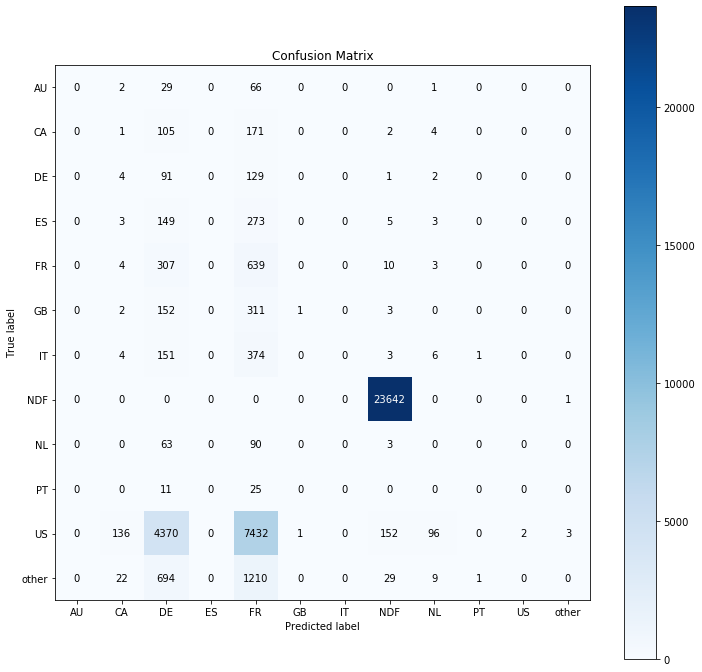

In [77]:
# Accuracy
acc_under_nn = m.accuracy_score( y_test_under_nn, yhat_under_nn )
print(f'Accuracy: {acc_under_nn}')

# Balanced Accuracy
balanced_acc_under_nn = m.balanced_accuracy_score(y_test_under_nn, yhat_under_nn)
print(f'Balanced Accuracy: {balanced_acc_under_nn}')

# Kappa Metrics
kappa_under_nn = m.cohen_kappa_score(y_test_under_nn, yhat_under_nn)
print(f'Kappa Score: {kappa_under_nn}')

# Classification report
print(m.classification_report(y_test_under_nn, yhat_under_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_under_nn, yhat_under_nn, normalize=False, figsize=(12,12));

# Performance
under_performance = {'model': 'NN Model - Random Undersampling', 
                     'acc': np.round(acc_under_nn, 6), 
                     'balanced_acc': np.round(balanced_acc_under_nn, 6), 
                     'kappa_score': np.round(kappa_under_nn, 6)}

#### 7.2.2.2. Random Undersampling - Cross-Validation

In [78]:
# cross validation performance
acc_under, balanced_acc_under, kappa_under = cross_validation(num_fold = 5, 
                                                              x_train = X_train, 
                                                              y_train = y_train, 
                                                              model = model_under, 
                                                              response_encoder = ohe, 
                                                              balance_model = undersampling, 
                                                              verbose = True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [79]:
# Performance
under_performance_cv = {'model': 'NN Model - Random Undersampling - CV',
                        'acc': f'{np.round(np.mean(acc_under), 2)} +/- {np.round(np.std(acc_under), 4)}',
                        'balanced_acc': f'{np.round(np.mean(balanced_acc_under), 2)} +/- {np.round(np.std(balanced_acc_under), 4)}',
                        'kappa_score': f'{np.round(np.mean(kappa_under), 2)} +/- {np.round(np.std(kappa_under), 4)}'}

In [80]:
print(f'Avg Accuracy: {np.round(np.mean(acc_under), 2)} +/- {np.round(np.std(acc_under),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_under), 2)} +/- {np.round(np.std(balanced_acc_under),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_under), 2)} +/- {np.round(np.std(kappa_under), 4)}')

Avg Accuracy: 0.62 +/- 0.02366
Avg Balanced Accuracy: 0.17 +/- 0.00566
Avg Kappa Score: 0.42 +/- 0.028


### 7.2.3. Random Oversampling 

In [81]:
# model definition
model_over = ml.Sequential()
model_over.add( l.Dense(128, input_dim=x_train_over.shape[1], activation='relu') )
model_over.add( l.Dense(12, activation='softmax') )

# model compile
model_over.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_over.fit(x_train_over, y_train_over, epochs=100)

Epoch 1/100
35829/35829 [==============================] - 42s 1ms/step - loss: 3.0967 - accuracy: 0.1727
Epoch 2/100
35829/35829 [==============================] - 48s 1ms/step - loss: 2.2005 - accuracy: 0.1677
Epoch 3/100
35829/35829 [==============================] - 39s 1ms/step - loss: 2.1994 - accuracy: 0.1678
Epoch 4/100
35829/35829 [==============================] - 39s 1ms/step - loss: 2.1991 - accuracy: 0.1681
Epoch 5/100
35829/35829 [==============================] - 48s 1ms/step - loss: 2.1989 - accuracy: 0.1682
Epoch 6/100
35829/35829 [==============================] - 35s 978us/step - loss: 2.1986 - accuracy: 0.1680
Epoch 7/100
35829/35829 [==============================] - 36s 999us/step - loss: 2.1985 - accuracy: 0.1686
Epoch 8/100
35829/35829 [==============================] - 32s 905us/step - loss: 2.1983 - accuracy: 0.1680
Epoch 9/100
35829/35829 [==============================] - 33s 914us/step - loss: 2.1982 - accuracy: 0.1685s - loss: 2.1982 - accura
Epoch 10/100


35829/35829 [==============================] - 31s 879us/step - loss: 2.1973 - accuracy: 0.1683
Epoch 77/100
35829/35829 [==============================] - 32s 885us/step - loss: 2.1973 - accuracy: 0.1684
Epoch 78/100
35829/35829 [==============================] - 31s 876us/step - loss: 2.1973 - accuracy: 0.1679
Epoch 79/100
35829/35829 [==============================] - 31s 872us/step - loss: 2.1972 - accuracy: 0.1683
Epoch 80/100
35829/35829 [==============================] - 32s 881us/step - loss: 2.1973 - accuracy: 0.1685
Epoch 81/100
35829/35829 [==============================] - 32s 886us/step - loss: 2.1972 - accuracy: 0.1685
Epoch 82/100
35829/35829 [==============================] - 32s 896us/step - loss: 2.1972 - accuracy: 0.1683
Epoch 83/100
35829/35829 [==============================] - 32s 892us/step - loss: 2.1974 - accuracy: 0.1681
Epoch 84/100
35829/35829 [==============================] - 31s 871us/step - loss: 2.1973 - accuracy: 0.1684
Epoch 85/100
35829/35829 [======

#### 7.2.3.1. Random Oversampling - Performance

In [82]:
# prediction
pred_over_nn = model_over.predict(x_test)

# invert prediction
yhat_over_nn = ohe.inverse_transform(pred_over_nn)

# invert validation response
y_test_over_nn = ohe.inverse_transform(y_test)

In [83]:
# check the balance of validation
pd.DataFrame(y_test_over_nn).value_counts(normalize=True)

NDF      0.576602
US       0.297337
other    0.047922
FR       0.023486
IT       0.013145
GB       0.011438
ES       0.010560
CA       0.006902
DE       0.005536
NL       0.003805
AU       0.002390
PT       0.000878
dtype: float64

In [84]:
# check balanced results
pd.DataFrame(yhat_over_nn).value_counts(normalize=True)

NDF    0.576871
GB     0.421105
PT     0.002024
dtype: float64

Accuracy: 0.5878207004194713
Balanced Accuracy: 0.16663494480395888
Kappa Score: 0.3778958881980867
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        98
          CA       0.00      0.00      0.00       283
          DE       0.00      0.00      0.00       227
          ES       0.00      0.00      0.00       433
          FR       0.00      0.00      0.00       963
          GB       0.03      1.00      0.05       469
          IT       0.00      0.00      0.00       539
         NDF       1.00      1.00      1.00     23643
          NL       0.00      0.00      0.00       156
          PT       0.00      0.00      0.00        36
          US       0.00      0.00      0.00     12192
       other       0.00      0.00      0.00      1965

    accuracy                           0.59     41004
   macro avg       0.09      0.17      0.09     41004
weighted avg       0.58      0.59      0.58     41004



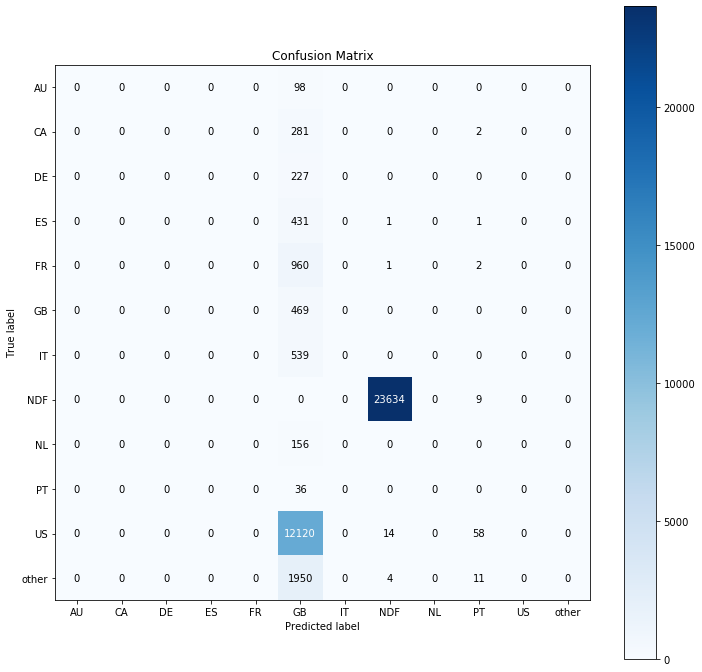

In [86]:
# Accuracy
acc_over_nn = m.accuracy_score( y_test_over_nn, yhat_over_nn )
print(f'Accuracy: {acc_over_nn}')

# Balanced Accuracy
balanced_acc_over_nn = m.balanced_accuracy_score(y_test_over_nn, yhat_over_nn)
print(f'Balanced Accuracy: {balanced_acc_over_nn}')

# Kappa Metrics
kappa_over_nn = m.cohen_kappa_score(y_test_over_nn, yhat_over_nn)
print(f'Kappa Score: {kappa_over_nn}')

# Classification report
print(m.classification_report(y_test_over_nn, yhat_over_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_over_nn, yhat_over_nn, normalize=False, figsize=(12,12));

# Performance
over_performance = {'model': 'NN Model - Random Oversampling', 
                    'acc': np.round(acc_over_nn, 6), 
                    'balanced_acc': np.round(balanced_acc_over_nn, 6), 
                    'kappa_score': np.round(kappa_over_nn, 6)}

#### 7.2.3.2. Random Oversampling - Cross-Validation

In [87]:
# cross validation performance
acc_over, balanced_acc_over, kappa_over = cross_validation(num_fold = 5, 
                                                           x_train = X_train, 
                                                           y_train = y_train, 
                                                           model = model_over, 
                                                           response_encoder = ohe, 
                                                           balance_model = oversampling, 
                                                           verbose = True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [88]:
# Performance
over_performance_cv = {'model': 'NN Model - Random Oversampling - CV',
                        'acc': f'{np.round(np.mean(acc_over), 2)} +/- {np.round(np.std(acc_over), 4)}',
                        'balanced_acc': f'{np.round(np.mean(balanced_acc_over), 2)} +/- {np.round(np.std(balanced_acc_over), 4)}',
                        'kappa_score': f'{np.round(np.mean(kappa_over), 2)} +/- {np.round(np.std(kappa_over), 4)}'}

In [89]:
print(f'Avg Accuracy: {np.round(np.mean(acc_over), 2)} +/- {np.round(np.std(acc_over),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_over), 2)} +/- {np.round(np.std(balanced_acc_over),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_over), 2)} +/- {np.round(np.std(kappa_over), 4)}')

Avg Accuracy: 0.6 +/- 0.0133
Avg Balanced Accuracy: 0.17 +/- 0.00034
Avg Kappa Score: 0.39 +/- 0.0155


### 7.2.4. Neural Network - SMOTE + TOMEKLINK

In [90]:
# model definition
model_comb = ml.Sequential()
model_comb.add( l.Dense(128, input_dim=x_train_comb.shape[1], activation='relu') )
model_comb.add( l.Dense(12, activation='softmax') )

# model compile
model_comb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_comb.fit(x_train_comb, y_train_comb, epochs=100)

Epoch 1/100
35752/35752 [==============================] - 35s 978us/step - loss: 3.3512 - accuracy: 0.1826
Epoch 2/100
35752/35752 [==============================] - 34s 948us/step - loss: 2.1994 - accuracy: 0.1668
Epoch 3/100
35752/35752 [==============================] - 34s 938us/step - loss: 2.1985 - accuracy: 0.1668
Epoch 4/100
35752/35752 [==============================] - 34s 946us/step - loss: 2.1984 - accuracy: 0.1670
Epoch 5/100
35752/35752 [==============================] - 34s 944us/step - loss: 2.1983 - accuracy: 0.1668
Epoch 6/100
35752/35752 [==============================] - 34s 956us/step - loss: 2.1982 - accuracy: 0.1670
Epoch 7/100
35752/35752 [==============================] - 35s 976us/step - loss: 2.1983 - accuracy: 0.1665
Epoch 8/100
35752/35752 [==============================] - 34s 948us/step - loss: 2.1982 - accuracy: 0.1674
Epoch 9/100
35752/35752 [==============================] - 35s 971us/step - loss: 2.1983 - accuracy: 0.1669
Epoch 10/100
35752/35752 [==

35752/35752 [==============================] - 33s 934us/step - loss: 2.1990 - accuracy: 0.1667
Epoch 77/100
35752/35752 [==============================] - 33s 937us/step - loss: 2.1987 - accuracy: 0.1665
Epoch 78/100
35752/35752 [==============================] - 34s 941us/step - loss: 2.1989 - accuracy: 0.1666
Epoch 79/100
35752/35752 [==============================] - 33s 934us/step - loss: 2.1997 - accuracy: 0.1669
Epoch 80/100
35752/35752 [==============================] - 34s 949us/step - loss: 2.1989 - accuracy: 0.1665
Epoch 81/100
35752/35752 [==============================] - 33s 934us/step - loss: 2.1989 - accuracy: 0.1669
Epoch 82/100
35752/35752 [==============================] - 34s 937us/step - loss: 2.1990 - accuracy: 0.1670
Epoch 83/100
35752/35752 [==============================] - 33s 931us/step - loss: 2.1985 - accuracy: 0.1665
Epoch 84/100
35752/35752 [==============================] - 34s 939us/step - loss: 2.1988 - accuracy: 0.1663
Epoch 85/100
35752/35752 [======

#### 7.2.4.1. SMOTE + TOMEKLINK - Performance

In [91]:
# prediction
pred_comb_nn = model_comb.predict(x_test)

# invert prediction
yhat_comb_nn = ohe.inverse_transform(pred_comb_nn)

# invert validation response
y_test_comb_nn = ohe.inverse_transform(y_test)

In [92]:
# check the balance of validation
pd.DataFrame(y_test_comb_nn).value_counts(normalize=True)

NDF      0.576602
US       0.297337
other    0.047922
FR       0.023486
IT       0.013145
GB       0.011438
ES       0.010560
CA       0.006902
DE       0.005536
NL       0.003805
AU       0.002390
PT       0.000878
dtype: float64

In [93]:
# check the balance of result
pd.DataFrame(yhat_comb_nn).value_counts(normalize=True)

NDF    0.576602
DE     0.423276
US     0.000122
dtype: float64

Accuracy: 0.5821627158326017
Balanced Accuracy: 0.16668012261318654
Kappa Score: 0.37181521405205487
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        98
          CA       0.00      0.00      0.00       283
          DE       0.01      1.00      0.03       227
          ES       0.00      0.00      0.00       433
          FR       0.00      0.00      0.00       963
          GB       0.00      0.00      0.00       469
          IT       0.00      0.00      0.00       539
         NDF       1.00      1.00      1.00     23643
          NL       0.00      0.00      0.00       156
          PT       0.00      0.00      0.00        36
          US       0.60      0.00      0.00     12192
       other       0.00      0.00      0.00      1965

    accuracy                           0.58     41004
   macro avg       0.13      0.17      0.09     41004
weighted avg       0.76      0.58      0.58     41004



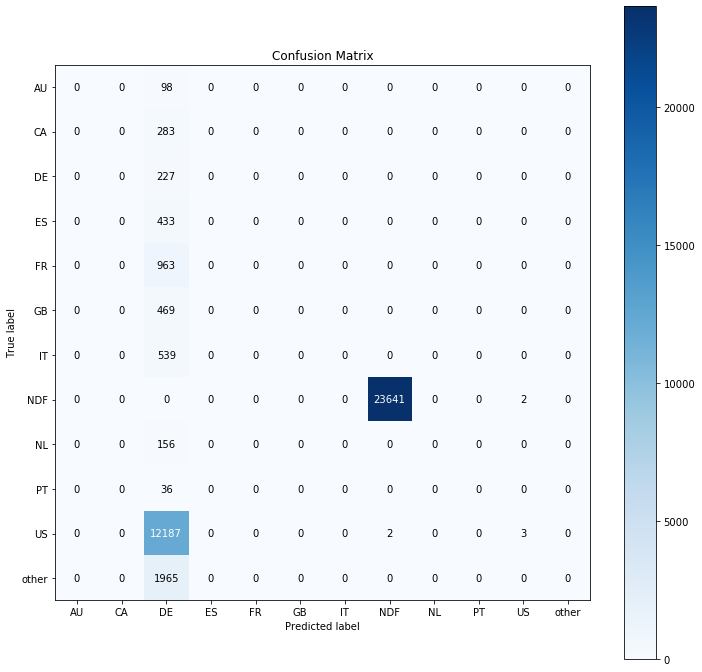

In [95]:
# Accuracy
acc_comb_nn = m.accuracy_score( y_test_comb_nn, yhat_comb_nn )
print(f'Accuracy: {acc_comb_nn}')

# Balanced Accuracy
balanced_acc_comb_nn = m.balanced_accuracy_score(y_test_comb_nn, yhat_comb_nn)
print(f'Balanced Accuracy: {balanced_acc_comb_nn}')

# Kappa Metrics
kappa_comb_nn = m.cohen_kappa_score(y_test_comb_nn, yhat_comb_nn)
print(f'Kappa Score: {kappa_comb_nn}')

# Classification report
print(m.classification_report(y_test_comb_nn, yhat_comb_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_comb_nn, yhat_comb_nn, normalize=False, figsize=(12,12));

# Performance
comb_performance = {'model': 'NN Model - SMOTE + TOMEKLINK', 
                    'acc': np.round(acc_comb_nn, 6), 
                    'balanced_acc': np.round(balanced_acc_comb_nn, 6), 
                    'kappa_score': np.round(kappa_comb_nn, 6)}

#### 7.2.4.2. SMOTE + TOMEKLINK - Cross-Validation

In [96]:
# cross validation performance
acc_comb, balanced_acc_comb, kappa_comb = cross_validation(num_fold = 5, 
                                                           x_train = X_train, 
                                                           y_train = y_train, 
                                                           model = model_comb, 
                                                           response_encoder = ohe, 
                                                           balance_model = combine, 
                                                           verbose = True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [97]:
# Performance
comb_performance_cv = {'model': 'NN Model - SMOTE + TOMEKLINK - CV',
                       'acc': f'{np.round(np.mean(acc_comb), 2)} +/- {np.round(np.std(acc_comb), 4)}',
                       'balanced_acc': f'{np.round(np.mean(balanced_acc_comb), 2)} +/- {np.round(np.std(balanced_acc_comb), 4)}',
                       'kappa_score': f'{np.round(np.mean(kappa_comb), 2)} +/- {np.round(np.std(kappa_comb), 4)}'}

In [98]:
print(f'Avg Accuracy: {np.round(np.mean(acc_comb), 2)} +/- {np.round(np.std(acc_comb),5)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_comb), 2)} +/- {np.round(np.std(balanced_acc_comb),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_comb), 2)} +/- {np.round(np.std(kappa_comb), 4)}')

Avg Accuracy: 0.59 +/- 0.00402
Avg Balanced Accuracy: 0.17 +/- 0.0004
Avg Kappa Score: 0.38 +/- 0.0046


# 8.0. Hyper Parameter Tuning

Hyper Parameter Tuning will not be considered until the most optimal machine learning model is selected, at this first cycle was considered only one model to complete the cycle and go through for all the major phases to validate the feasibility of the project.

# 9.0. Error Translation and Interpretation

# 10.0. Deploy Model

No models will be deployed yet.

# 11.0. Conclusion

The use of 3 mechanisms to obtain a balanced distribution of classes was considered, including Random Undersampling, Random Oversampling and a synthetic sampling with data generation (SMOTE + Tomek Links).

All the mechanisms present similar performance, decreasing in all the metrics compared to the previous cycle.

All balanced datasets showed similar results of Kappa Score, presenting a drop of 57% (0.77 to 0.40) in the balancing mechanisms.

Another difference observed was in the distribution of classes in the prediction data, with a greater plurality, especially in undersampling mechanism, previously concentrated between the two marjority classes (NDF and US).

All the mechanisms will be maintained until the data preparation phase to evaluate the impact on results and verify if the imbalanced dataset mechanism will continue with the best model's performance metrics.

## 11.1. Current Cycle Performance

In [115]:
# performance dataframe
df_performance = pd.DataFrame([baseline_performance, imb_performance, imb_performance_cv, 
                               under_performance, under_performance_cv, 
                               over_performance, over_performance_cv, 
                               comb_performance, comb_performance_cv])

df_performance['cycle'] = '5th_cycle'
df_performance['process'] = 'balanced_dataset'
df_performance = df_performance[['cycle', 'process', 'model', 'acc', 'balanced_acc', 'kappa_score']]

# save 5th cycle to comparison
df_performance.to_csv('../Datasets/5th_cycle_performance', index=False)

# display performance dataframe
df_performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,5th_cycle,balanced_dataset,Baseline Model,0.426544,0.083897,NaN
1,5th_cycle,balanced_dataset,NN Model - Imbalanced Data,0.873793,0.166626,0.766969
2,5th_cycle,balanced_dataset,NN Model - Imbalanced Data - CV,0.87 +/- 0.0001,0.17 +/- 0.0,0.77 +/- 0.0002
3,5th_cycle,balanced_dataset,NN Model - Random Undersampling,0.594479,0.172518,0.383323
4,5th_cycle,balanced_dataset,NN Model - Random Undersampling - CV,0.62 +/- 0.0237,0.17 +/- 0.0057,0.42 +/- 0.028
5,5th_cycle,balanced_dataset,NN Model - Random Oversampling,0.587821,0.166635,0.377896
6,5th_cycle,balanced_dataset,NN Model - Random Oversampling - CV,0.6 +/- 0.0133,0.17 +/- 0.0003,0.39 +/- 0.0155
7,5th_cycle,balanced_dataset,NN Model - SMOTE + TOMEKLINK,0.582163,0.16668,0.371815
8,5th_cycle,balanced_dataset,NN Model - SMOTE + TOMEKLINK - CV,0.59 +/- 0.004,0.17 +/- 0.0004,0.38 +/- 0.0046


## 11.2. Cycle Comparison

In [116]:
# first cycle performance load
performance_1st_cycle = pd.read_csv('../Datasets/1st_cycle_performance')

# second cycle performance load
performance_2nd_cycle = pd.read_csv('../Datasets/2nd_cycle_performance')

# third cycle performance load
performance_3rd_cycle = pd.read_csv('../Datasets/3rd_cycle_performance')

# fourth cycle performance load
performance_4th_cycle = pd.read_csv('../Datasets/4th_cycle_performance')

# join cycles dataframes
performance = pd.concat([performance_1st_cycle, 
                         performance_2nd_cycle, 
                         performance_3rd_cycle[performance_3rd_cycle['model'] == 'Neural Network Model - CV'], 
                         performance_4th_cycle[performance_4th_cycle['model'] == 'Neural Network Model - CV'], 
                         df_performance[df_performance['model'] == 'NN Model - Imbalanced Data - CV']])\
                        .reset_index(drop=True)

# filter baseline model
performance = performance[performance['model'] != 'Baseline Model'].fillna(0)

# display performance
performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,1st_cycle,validation_pipeline,Neural Network Model,0.70407,0,0
2,2nd_cycle,baseline_model,Neural Network Model,0.70275,0.091927,0.002145
3,3rd_cycle,replace_na,Neural Network Model - CV,0.63 +/- 0.0013,0.11 +/- 0.0009,0.24 +/- 0.0063
4,4th_cycle,feature_engineering,Neural Network Model - CV,0.87 +/- 0.0,0.17 +/- 0.0,0.77 +/- 0.0001
5,5th_cycle,balanced_dataset,NN Model - Imbalanced Data - CV,0.87 +/- 0.0001,0.17 +/- 0.0,0.77 +/- 0.0002


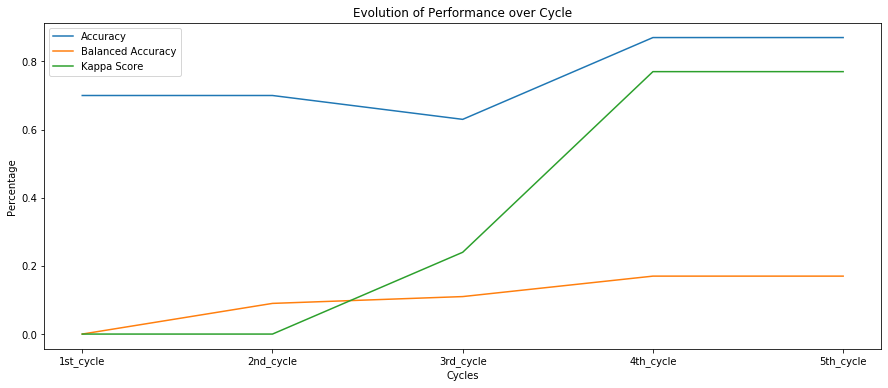

In [117]:
plt.figure(figsize=(15,6))

# formated metrics
performance['acc'] = performance['acc'].apply(lambda x: str(x)[0:4]).astype(float)

performance['balanced_acc'] = performance['balanced_acc'].apply(lambda x: str(x)[0:4]).astype(float)

performance['kappa_score'] = performance['kappa_score'].apply(lambda x: str(x)[0:4]).astype(float)


# Evolution of Performance over Cycles
sns.lineplot(x='cycle', y='acc', data=performance)

sns.lineplot(x='cycle', y='balanced_acc', data=performance)

sns.lineplot(x='cycle', y='kappa_score', data=performance)

# set legend and titles
plt.legend(labels=['Accuracy','Balanced Accuracy', 'Kappa Score'])
plt.title('Evolution of Performance over Cycle')
plt.ylabel('Percentage')
plt.xlabel('Cycles');

In [118]:
performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,1st_cycle,validation_pipeline,Neural Network Model,0.70,0.00,0.00
2,2nd_cycle,baseline_model,Neural Network Model,0.70,0.09,0.00
3,3rd_cycle,replace_na,Neural Network Model - CV,0.63,0.11,0.24
4,4th_cycle,feature_engineering,Neural Network Model - CV,0.87,0.17,0.77
5,5th_cycle,balanced_dataset,NN Model - Imbalanced Data - CV,0.87,0.17,0.77
